In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd

/root


In [4]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#import kaggle
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Kütüphane Tanımları

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
# img_to_array fonksiyonu görseli matrise çeviriyor
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import time
import datetime

Tensorboard yükleme

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
%rm -rf ./logs/

Verileri yüklemek

In [ ]:
data_dir= "/content/gdrive/MyDrive/Kaggle/COVID-19 Radiography Database/"
covid_data_path = data_dir+"COVID-19/"
normal_data_path = data_dir+"NORMAL/"

Görsel göstermek

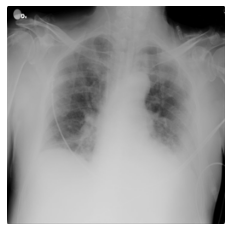

In [ ]:
img = load_img(covid_data_path+"COVID-19 (1).png")
plt.imshow(img)
# matristeki x ,y axisleri kaldırdık
plt.axis("off")
plt.show()

Örnek 5 tane veriyi görselleştirme,tahmin etmek ve tahmin ihtimalleri

CNN modelimiz

In [ ]:
# Used Sequential
model=tf.keras.Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [ ]:
img_height, img_width=224,224
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3,rotation_range=0.1,zoom_range=0.2,rescale=1./255) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    subset='validation') # set as validation data

Found 1740 images belonging to 2 classes.
Found 744 images belonging to 2 classes.


In [ ]:
# Defining optimizer
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Training the model
startCNN=time.time()
trainer=model.fit(train_generator,validation_data=validation_generator,epochs=5,callbacks=[tensorboard_callback])
stopCNN=time.time()
print(stopCNN-startCNN)

Epoch 1/5
109/109 [==============================] - 49s 424ms/step - loss: 0.6370 - accuracy: 0.7558 - val_loss: 0.1009 - val_accuracy: 0.9637
Epoch 2/5
109/109 [==============================] - 46s 420ms/step - loss: 0.1224 - accuracy: 0.9626 - val_loss: 0.1669 - val_accuracy: 0.9435
Epoch 3/5
109/109 [==============================] - 46s 420ms/step - loss: 0.0769 - accuracy: 0.9767 - val_loss: 0.1386 - val_accuracy: 0.9556
Epoch 4/5
109/109 [==============================] - 46s 421ms/step - loss: 0.0989 - accuracy: 0.9704 - val_loss: 0.0525 - val_accuracy: 0.9772
Epoch 5/5
109/109 [==============================] - 46s 427ms/step - loss: 0.0814 - accuracy: 0.9737 - val_loss: 0.0520 - val_accuracy: 0.9812
234.05978655815125


In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
nb_samples = len(validation_generator)
y_pred = []
y_act=[]
p=0
for i in range(nb_samples):
  x,y=validation_generator.next()
  y_act.append(y)
  if model.predict(x)>0.5:
    y_pred.append(1)
  else : y_pred.append(0)
  if y_pred[i]==y_act[i]:
    p+=1


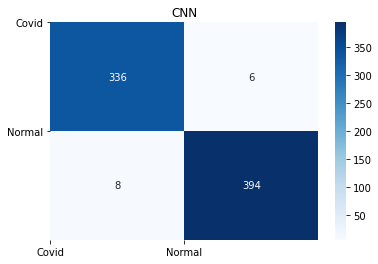

730


In [ ]:
cm=confusion_matrix(y_act,y_pred)

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.title("CNN")
plt.xticks([0,1], ["Covid","Normal"])
plt.yticks([0,1], ["Covid","Normal"],rotation=0)
plt.show()
print(p)

In [ ]:
names= ['Covid-19','Sağlıklı']
print(classification_report(y_act, y_pred, target_names=names))


              precision    recall  f1-score   support

    Covid-19       0.98      0.98      0.98       342
    Sağlıklı       0.98      0.98      0.98       402

    accuracy                           0.98       744
   macro avg       0.98      0.98      0.98       744
weighted avg       0.98      0.98      0.98       744

